# 1. Environment and project setup

### Section 1.1: Importing Libraries and GPU Configuration
This block imports necessary libraries for data processing (`os`, `numpy`, `librosa`) and model building using TensorFlow/Keras. It also verifies GPU availability to ensure the system leverages hardware acceleration.


In [1]:
# Import libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import random

# Ensure TensorFlow uses GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

2025-01-19 10:59:15.786045: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 10:59:15.811729: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0
GPUs Available: []


### Section 1.2: Dataset Path Initialization
Defines paths for the ASVspoof2019 Logical Access dataset (training, validation, and test sets) along with their corresponding protocol files. This setup ensures structured access to audio and label data for preprocessing and model training.


In [2]:
# Dataset paths
DATASET_PATH = "/mnt/c/DF/LA/"
DATASET_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_train/flac")  # Path to training audio files
DATASET_VAL = os.path.join(DATASET_PATH, "ASVspoof2019_LA_dev/flac")     # Path to validation audio files
DATASET_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_eval/flac")   # Path to test audio files

# Label files contain the protocol for bonafide/spoof labels for each audio file
LABELS_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt")
LABELS_VAL = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt")
LABELS_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt")

# Print paths to verify correctness
print("Train Dataset Path:", DATASET_TRAIN)
print("Labels Train Path:", LABELS_TRAIN)

Train Dataset Path: /mnt/c/DF/LA/ASVspoof2019_LA_train/flac
Labels Train Path: /mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt


### Section 1.3: Audio Preprocessing Configuration
Defines key parameters for audio preprocessing:
- **Sample rate:** 16 kHz to ensure uniformity.
- **Clip duration:** 5 seconds to standardize input length.
- **Mel bins:** 128 for Mel spectrogram generation.
The number of classes is set to 2 for binary classification (bonafide vs. spoof).


In [3]:
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins
RANDOM_STATE = 2159081 # For reproducibility
MAX_TIME_STEPS = 109  # Define the maximum time steps for your model

random.seed(RANDOM_STATE)  # For reproducibility

# 2. Loading dataset labels
### Section 2.1: Loading Labels from Protocol Files
This block defines and uses a function to load labels from ASVspoof protocol files. Labels are mapped to filenames and stored in a dictionary for easy retrieval. The function processes training, validation, and test datasets, and their label counts and examples are printed for verification.


In [4]:
# Define a function to load labels from the protocol file
def load_labels(file_path):
    labels = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Example protocol line: <file_id> <label>
            file_id, filename, label = parts[0], parts[1], parts[-1]
            labels[filename] = label
    return labels

# Load training labels
train_labels = load_labels(LABELS_TRAIN)
test_labels = load_labels(LABELS_VAL)
test_unseen_labels = load_labels(LABELS_TEST)

# Print some examples
print("Number of training samples:", len(train_labels))
print("Training example label:", list(train_labels.items())[:5])
print("Number of testing samples:", len(test_labels))
print("Testing example label:", list(test_labels.items())[:5])
print("Number of (unseen) testing samples:", len(test_unseen_labels))
print("Testing (unseen) example label:", list(test_unseen_labels.items())[:5])

Number of training samples: 25380
Training example label: [('LA_T_1138215', 'bonafide'), ('LA_T_1271820', 'bonafide'), ('LA_T_1272637', 'bonafide'), ('LA_T_1276960', 'bonafide'), ('LA_T_1341447', 'bonafide')]
Number of testing samples: 24844
Testing example label: [('LA_D_1047731', 'bonafide'), ('LA_D_1105538', 'bonafide'), ('LA_D_1125976', 'bonafide'), ('LA_D_1293230', 'bonafide'), ('LA_D_1340209', 'bonafide')]
Number of (unseen) testing samples: 71237
Testing (unseen) example label: [('LA_E_2834763', 'spoof'), ('LA_E_8877452', 'spoof'), ('LA_E_6828287', 'spoof'), ('LA_E_6977360', 'spoof'), ('LA_E_5932896', 'spoof')]


### Section 2.2: Split validation and training set

In [5]:
def shuffle_and_split_dict(input_dict, n=10000):
    """
    Shuffle the input dictionary and return two new dictionaries with the first n elements and last len-n elements.

    Args:
        input_dict (dict): The dictionary to shuffle and split.
        n (int): The number of elements to keep after shuffle. Default is 10,000.

    Returns:
        dict: Two shuffled dictionaries.
    """
    # Convert dictionary items to a list and shuffle
    items = list(input_dict.items())
    random.shuffle(items)

    # Trim the list to the first n elements and recreate the dictionary
    first_dict = dict(items[:n])
    second_dict = {k: input_dict[k] for k in input_dict if k not in first_dict}

    return first_dict, second_dict

val_labels, train_labels = shuffle_and_split_dict(train_labels, int(len(train_labels)/3))

# Print some examples
print("Number of training samples:", len(train_labels))
print("Training example label:", list(train_labels.items())[:5])
print("Number of validation samples:", len(val_labels))
print("Validation example label:", list(val_labels.items())[:5])
print("Number of testing samples:", len(test_labels))
print("Testing example label:", list(test_labels.items())[:5])
print("Number of testing (unseen) samples:", len(test_unseen_labels))
print("Testing example (unseen) label:", list(test_unseen_labels.items())[:5])

Number of training samples: 16920
Training example label: [('LA_T_1138215', 'bonafide'), ('LA_T_1272637', 'bonafide'), ('LA_T_1276960', 'bonafide'), ('LA_T_1363611', 'bonafide'), ('LA_T_1596451', 'bonafide')]
Number of validation samples: 8460
Validation example label: [('LA_T_1320614', 'spoof'), ('LA_T_7317351', 'spoof'), ('LA_T_6991105', 'spoof'), ('LA_T_7853091', 'spoof'), ('LA_T_9032022', 'bonafide')]
Number of testing samples: 24844
Testing example label: [('LA_D_1047731', 'bonafide'), ('LA_D_1105538', 'bonafide'), ('LA_D_1125976', 'bonafide'), ('LA_D_1293230', 'bonafide'), ('LA_D_1340209', 'bonafide')]
Number of testing (unseen) samples: 71237
Testing example (unseen) label: [('LA_E_2834763', 'spoof'), ('LA_E_8877452', 'spoof'), ('LA_E_6828287', 'spoof'), ('LA_E_6977360', 'spoof'), ('LA_E_5932896', 'spoof')]


### Section 2.3 Reduce data for test speed

In [6]:
def shuffle_and_trim_dict(input_dict, n=10000):
    """
    Shuffle the input dictionary and return a new dictionary with the first n elements.

    Args:
        input_dict (dict): The dictionary to shuffle and trim.
        n (int): The number of elements to keep after shuffle. Default is 10,000.

    Returns:
        dict: A shuffled dictionary with up to n elements.
    """
    # Convert dictionary items to a list and shuffle
    items = list(input_dict.items())
    random.shuffle(items)

    # Trim the list to the first n elements and recreate the dictionary
    trimmed_dict = dict(items[:n])

    return trimmed_dict

# ATTENTION: Dataset limiting --------------------------------
#train_labels = shuffle_and_trim_dict(train_labels, n=100)
#val_labels = shuffle_and_trim_dict(val_labels, n=100)
#test_labels = shuffle_and_trim_dict(test_labels, n=100)
test_unseen_labels = shuffle_and_trim_dict(test_unseen_labels, n=20000)
# ATTENTION: Dataset limiting --------------------------------

# Print some examples
print("Number of training samples:", len(train_labels))
print("Training example label:", list(train_labels.items())[:5])
print("Number of validation samples:", len(val_labels))
print("Validation example label:", list(val_labels.items())[:5])
print("Number of testing samples:", len(test_labels))
print("Testing example label:", list(test_labels.items())[:5])
print("Number of testing (unseen) samples:", len(test_unseen_labels))
print("Testing example (unseen) label:", list(test_unseen_labels.items())[:5])

Number of training samples: 16920
Training example label: [('LA_T_1138215', 'bonafide'), ('LA_T_1272637', 'bonafide'), ('LA_T_1276960', 'bonafide'), ('LA_T_1363611', 'bonafide'), ('LA_T_1596451', 'bonafide')]
Number of validation samples: 8460
Validation example label: [('LA_T_1320614', 'spoof'), ('LA_T_7317351', 'spoof'), ('LA_T_6991105', 'spoof'), ('LA_T_7853091', 'spoof'), ('LA_T_9032022', 'bonafide')]
Number of testing samples: 24844
Testing example label: [('LA_D_1047731', 'bonafide'), ('LA_D_1105538', 'bonafide'), ('LA_D_1125976', 'bonafide'), ('LA_D_1293230', 'bonafide'), ('LA_D_1340209', 'bonafide')]
Number of testing (unseen) samples: 20000
Testing example (unseen) label: [('LA_E_1230806', 'spoof'), ('LA_E_3107506', 'spoof'), ('LA_E_1313729', 'spoof'), ('LA_E_4249502', 'spoof'), ('LA_E_4448653', 'spoof')]


# 3. Files loading and Preprocessing
### Section 3.1: Loading Dataset Files and MEL Spectrogram Conversion
- A function `load_dataset_files` is defined to:
  - Load audio files.
  - Convert them to Mel spectrograms using `librosa`.
  - Standardize their dimensions using padding or trimming to fit a fixed time step (`MAX_TIME_STEPS`).
- A progress bar (`tqdm`) is used to visualize file loading operations.
- The function processes and loads the training, validation, and testing datasets, ensuring the data is ready for model input.

In [7]:
from tqdm import tqdm

# Function to load audio files and convert them to Mel spectrograms
def load_dataset_files(dataset_path, dataset_labels):
    """
    Loads audio files from a given dataset path, converts them to Mel spectrograms, 
    and ensures all spectrograms have the same size.

    Args:
        dataset_path (str): Path to the dataset containing audio files.
        dataset_labels (dict): Dictionary mapping file names to their labels.

    Returns:
        X (np.array): Array of Mel spectrograms.
        y (np.array): Array of corresponding labels.
    """
    X = []
    y = []
    
    # Iterate over each file and its label
    for file_name, label in tqdm(dataset_labels.items(), desc="Loading and converting files"):
        file_path = os.path.join(dataset_path, file_name + ".flac")
        
        try:
            # Load audio file with librosa
            audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
            
            # Compute Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to decibel scale
            
            # Adjust spectrogram time steps to MAX_TIME_STEPS
            if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
                # Pad if time steps are less than MAX_TIME_STEPS
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
            else:
                # Trim if time steps exceed MAX_TIME_STEPS
                mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]
            
            X.append(mel_spectrogram)
            y.append(label)
        
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

# Load the datasets
print("Loading training dataset...")
X_train, y_train = load_dataset_files(DATASET_TRAIN, train_labels)
print("Loading validation dataset...")
X_val, y_val = load_dataset_files(DATASET_TRAIN, val_labels)
print("Loading testing dataset...")
X_test, y_test = load_dataset_files(DATASET_VAL, test_labels)
print("Loading unseen testing dataset...")
X_unseen_test, y_unseen_test = load_dataset_files(DATASET_TEST, test_unseen_labels)

# Verify shapes
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"(Unseen) Testing data shape: {X_unseen_test.shape}, Labels shape: {y_unseen_test.shape}")

Loading training dataset...


Loading and converting files: 100%|███████████████████████████████████████████████| 16920/16920 [06:40<00:00, 42.30it/s]


Loading validation dataset...


Loading and converting files: 100%|█████████████████████████████████████████████████| 8460/8460 [03:19<00:00, 42.49it/s]


Loading testing dataset...


Loading and converting files: 100%|███████████████████████████████████████████████| 24844/24844 [08:36<00:00, 48.08it/s]


Loading unseen testing dataset...


Loading and converting files: 100%|███████████████████████████████████████████████| 20000/20000 [07:14<00:00, 46.02it/s]


Training data shape: (16920, 128, 109), Labels shape: (16920,)
Validation data shape: (8460, 128, 109), Labels shape: (8460,)
Testing data shape: (24844, 128, 109), Labels shape: (24844,)
(Unseen) Testing data shape: (20000, 128, 109), Labels shape: (20000,)


### Section 3.2: Plotting Sample Mel Spectrograms
- Visualizes one sample Mel spectrogram from the training, validation, and testing datasets.
- Each spectrogram is displayed with appropriate labels, including a color bar for decibel values.

Plotting sample Mel spectrograms...


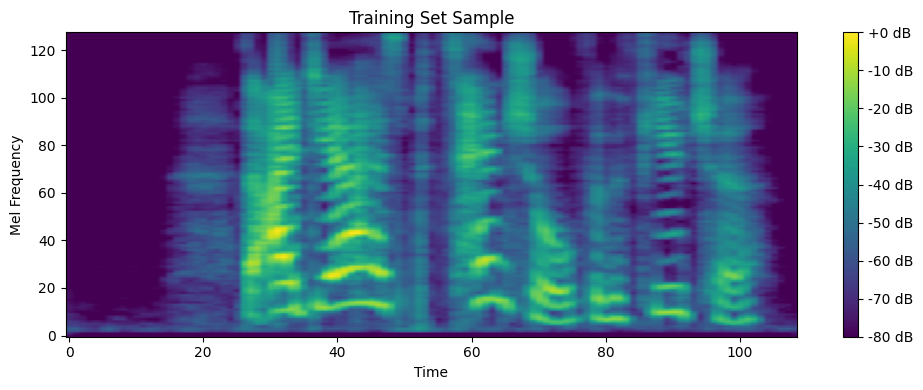

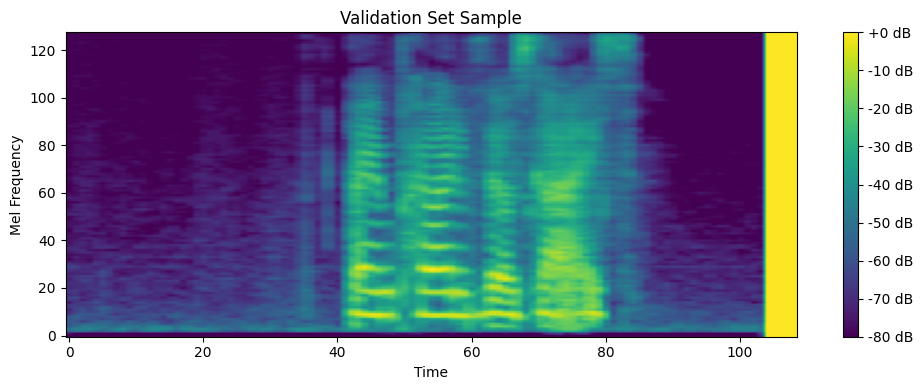

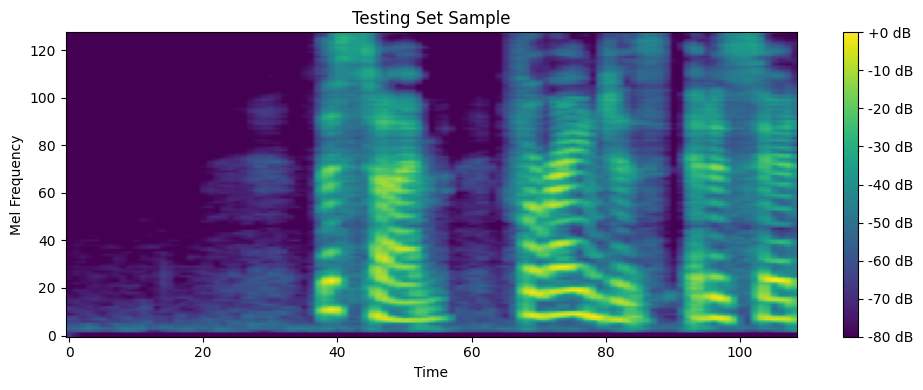

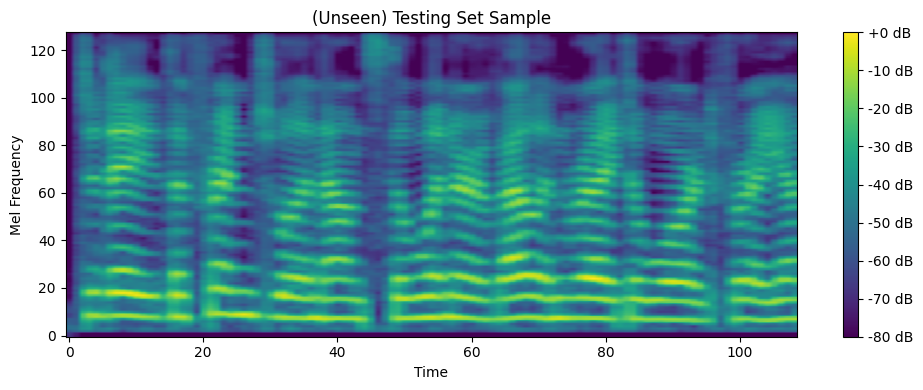

In [8]:
import matplotlib.pyplot as plt

# Function to plot a Mel spectrogram
def plot_mel_spectrogram(mel_spectrogram, title):
    """
    Plots a single Mel spectrogram.

    Args:
        mel_spectrogram (np.array): Mel spectrogram to plot.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.tight_layout()
    plt.show()

# Plot samples from training, validation, and testing sets
print("Plotting sample Mel spectrograms...")
plot_mel_spectrogram(X_train[0], "Training Set Sample")
plot_mel_spectrogram(X_val[0], "Validation Set Sample")
plot_mel_spectrogram(X_test[0], "Testing Set Sample")
plot_mel_spectrogram(X_unseen_test[0], "(Unseen) Testing Set Sample")

### Section 3.3: One-Hot Encoding of Labels
This section encodes the integer labels (`bonafide` and `spoof`) into a one-hot format using the `to_categorical` function from Keras. This step prepares the labels for categorical classification tasks, aligning with the requirements of the categorical cross-entropy loss function. 

- **Input Example:** A label `0` becomes `[1, 0]`, and `1` becomes `[0, 1]`.
- **Consistency:** Encoding is applied to the training, validation, and test labels.

Key Benefits:
- Ensures compatibility with classification models.
- Simplifies the training process by providing a clear categorical representation of the labels.


In [9]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Map labels from strings to integers
label_mapping = {"bonafide": 0, "spoof": 1}
y_train = np.array([label_mapping[label] for label in y_train])
y_val = np.array([label_mapping[label] for label in y_val])
y_test = np.array([label_mapping[label] for label in y_test])
y_unseen_test = np.array([label_mapping[label] for label in y_unseen_test])

# Convert integer labels to one-hot encoded format
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)
y_unseen_test = to_categorical(y_unseen_test, NUM_CLASSES)

### Section 3.4: Dataset backup

In [10]:
if "backups_created" not in globals():
    X_test_backup = X_test
    y_test_backup = y_test
    X_val_backup = X_val
    y_val_backup = y_val
    backups_created = True  # Imposta la flag
    print("Backups created.")
else:
    print("Backups already exist. This cell will not create them again.")

X_test = X_test_backup
y_test = y_test_backup
X_val = X_val_backup
y_val = y_val_backup
print("Recovered backup.")

# Verify shapes
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"(Unseen) Testing data shape: {X_unseen_test.shape}, Labels shape: {y_unseen_test.shape}")

Backups created.
Recovered backup.
Training data shape: (16920, 128, 109), Labels shape: (16920, 2)
Validation data shape: (8460, 128, 109), Labels shape: (8460, 2)
Testing data shape: (24844, 128, 109), Labels shape: (24844, 2)
(Unseen) Testing data shape: (20000, 128, 109), Labels shape: (20000, 2)


# 4. Define and train the CNN Model
### Section 4.1: Defining the CNN Model Architecture
This section defines a Convolutional Neural Network (CNN) designed for the classification of Mel spectrograms into `bonafide` and `spoof` classes. The architecture includes:

1. **Input Layer:**
   - Takes Mel spectrograms as input with a shape `(N_MELS, time_steps, 1)`.

2. **Convolutional Layers:**
   - Extract features using 32 and 64 filters with a kernel size of 3x3, applying ReLU activation for non-linear feature mapping.

3. **Pooling Layers:**
   - `MaxPooling2D` reduces the spatial size, making the network computationally efficient and summarizing important features.

4. **Fully Connected Layers:**
   - A `Dense` layer with 128 neurons captures global patterns, followed by a `Dropout` layer (50%) to prevent overfitting.
   - The final `Dense` layer with `NUM_CLASSES` neurons and `softmax` activation provides class probabilities.

5. **Model Compilation:**
   - **Optimizer:** Adam, known for adaptive learning rates.
   - **Loss Function:** Categorical Crossentropy for multi-class classification.
   - **Metric:** Accuracy to evaluate model performance.

This model is optimized for the task of detecting fake audio (spoof) from genuine audio (bonafide).


In [11]:
# Define CNN model architecture
input_shape = (N_MELS, X_train.shape[2], 1)  # Input shape for CNN (height, width, channels)
model_input = Input(shape=input_shape)  # Input layer for the model

# First convolutional layer with 32 filters and ReLU activation
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)

# First max pooling layer to reduce spatial dimensions
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second convolutional layer with 64 filters and ReLU activation
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)

# Second max pooling layer
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flattening the output from convolutional layers to prepare for dense layers
x = Flatten()(x)

# Fully connected dense layer with 128 neurons and ReLU activation
x = Dense(128, activation='relu')(x)

# Dropout layer to reduce overfitting by randomly setting 50% of inputs to zero
x = Dropout(0.5)(x)

# Output layer with softmax activation for multi-class classification
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the complete model
model = Model(inputs=model_input, outputs=model_output)

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### Section 4.2 Train the model

In [12]:
# Train the Model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.8791 - loss: 3.0138 - val_accuracy: 0.9035 - val_loss: 0.2070
Epoch 2/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.9194 - loss: 0.1889 - val_accuracy: 0.9626 - val_loss: 0.1121
Epoch 3/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step - accuracy: 0.9458 - loss: 0.1318 - val_accuracy: 0.9551 - val_loss: 0.1141
Epoch 4/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.9642 - loss: 0.0931 - val_accuracy: 0.9767 - val_loss: 0.0710
Epoch 5/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.9716 - loss: 0.0753 - val_accuracy: 0.9671 - val_loss: 0.0803
Epoch 6/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.9760 - loss: 0.0642 - val_accuracy: 0.9778 - val_loss: 0.0635
Epoch 7/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.9839 - loss: 0.0464 - val_accuracy: 0.9862 - val_loss: 0.0446
Epoch 8/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.9793 - loss: 0.0596 - 

### Section 4.3: Saving the Model with Dynamic Filename
This section dynamically saves the trained model with a filename that includes the current date and time, ensuring each save operation generates a unique file. The filename is stored in the variable `model_filename` for future use. Example filename: `CNN_Model_20250117_153045.h5`.


In [13]:
from datetime import datetime

# Generate a dynamic filename with the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
model_filename = f"CNN_Model_{current_time}.h5"  # Dynamic model filename

# Save the model
model.save(model_filename)

print(f"Model saved as: {model_filename}")


Model saved as: CNN_Model_20250119_1130.h5


### Section 4.4: Visualizing the Model Architecture
This section generates a graphical representation of the CNN model architecture, including:
- **Layer Names:** Each layer's type and name.
- **Shapes:** Input and output tensor shapes for each layer, aiding in debugging and understanding the flow of data through the network.

The visualization is saved as `model_architecture.png` and displayed inline for easy reference. This graphical summary provides insights into the structure, depth, and connectivity of the model.


In [14]:
!pip install graphviz pydot
# sudo apt-get install graphviz

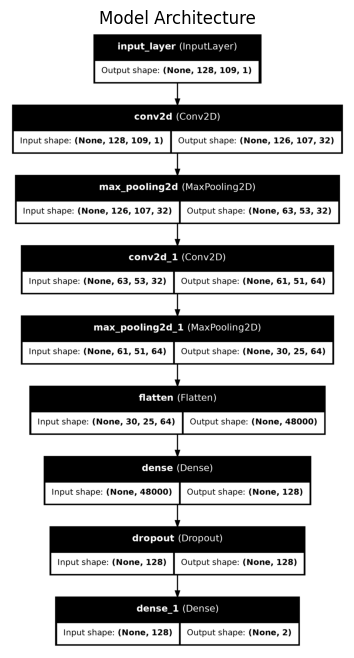

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plt.figure(figsize=(12, 8))
plot_model(model, to_file="MEL_CNN_Unbalanced_Architecture.png", show_shapes=True, show_layer_names=True)
img = plt.imread("MEL_CNN_Unbalanced_Architecture.png")
plt.imshow(img)
plt.axis('off')
plt.title("Model Architecture")
plt.show()

# 5. Data Visualisation & Testing
### Section 5.1: Plotting Confusion Matrix and ROC Curve
This section evaluates the trained model on the training set by:
1. **Confusion Matrix:**
   - Displays a confusion matrix showing the counts of correctly and incorrectly classified samples for each class.

2. **ROC Curve:**
   - Plots the Receiver Operating Characteristic (ROC) curve to visualize the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR).
   - Computes and annotates the Area Under the Curve (AUC) score to measure the model's ability to discriminate between classes.

These visualizations help assess the performance of the model on the training dataset.


529/529 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step


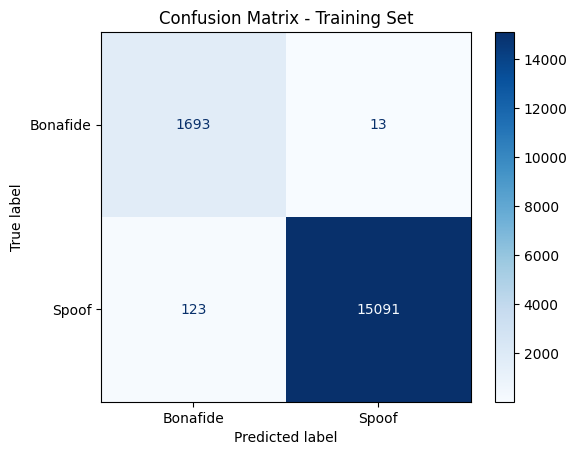

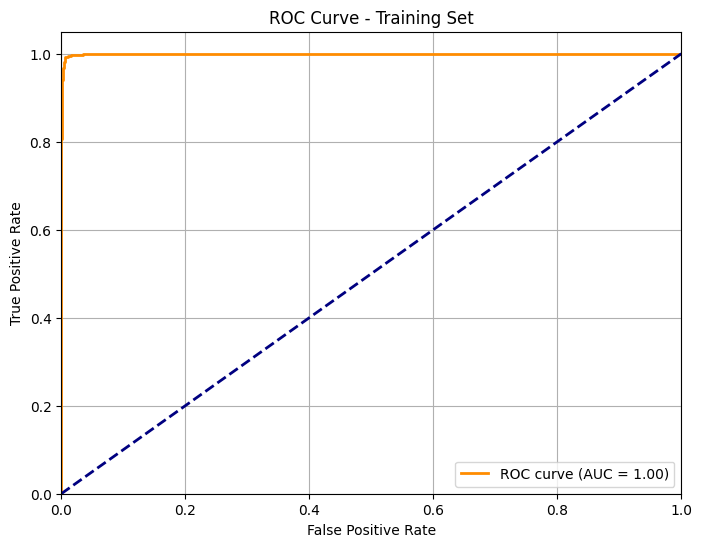

In [16]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import numpy as np

# Load the saved model
model = load_model(model_filename)

# Predict on the training set
train_predictions = model.predict(X_train)
train_pred_classes = np.argmax(train_predictions, axis=1)
train_true_classes = np.argmax(y_train, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(train_true_classes, train_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Bonafide", "Spoof"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Training Set")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(train_true_classes, train_predictions[:, 1])  # Use the positive class probabilities
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Training Set")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Section 5.2: Evaluation on the Test Set
This section evaluates the trained model on the test set using the following metrics:

1. **Confusion Matrix:**
   - Displays the confusion matrix, summarizing the number of correct and incorrect predictions for each class (`Bonafide` and `Spoof`).
   - Helps in understanding the model’s performance in terms of true positives, true negatives, false positives, and false negatives.

2. **ROC Curve:**
   - Plots the Receiver Operating Characteristic (ROC) curve, which visualizes the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR) at various thresholds.
   - Computes the Area Under the Curve (AUC) score to quantify the model’s classification performance.

3. **Precision-Recall Curve:**
   - Plots the Precision-Recall (PR) curve, which is particularly useful for imbalanced datasets.
   - Precision measures the proportion of true positives out of all positive predictions.
   - Recall (or sensitivity) measures the proportion of true positives out of all actual positives.
   - Computes the Average Precision (AP) score, which summarizes the PR curve into a single value.

These metrics provide a comprehensive evaluation of the model’s ability to distinguish between `Bonafide` and `Spoof` samples on unseen data, highlighting both its accuracy and robustness.


777/777 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step


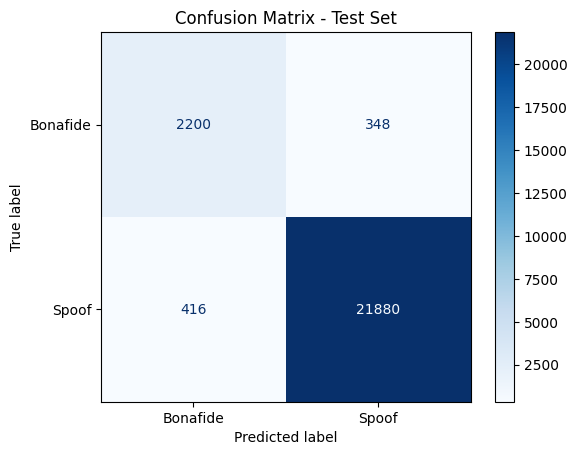

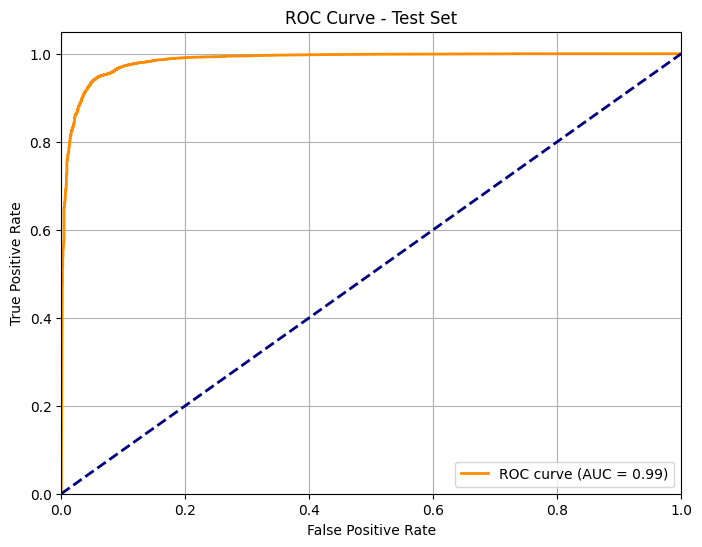

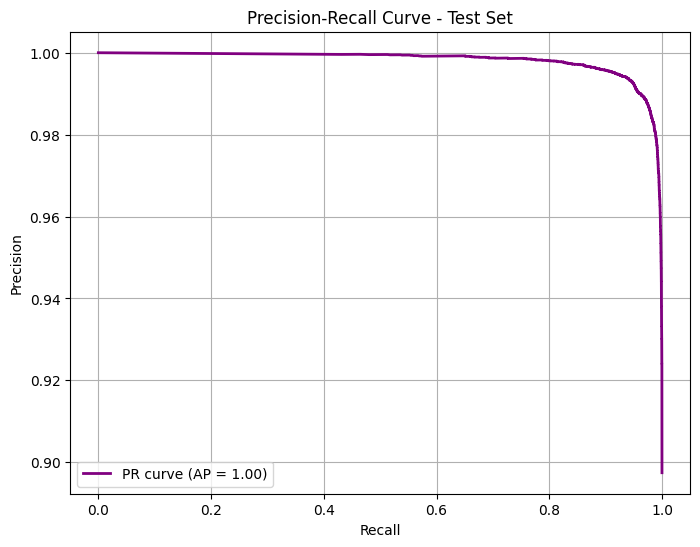

In [17]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# Predict on the testing set
test_predictions = model.predict(X_test)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Bonafide", "Spoof"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_true_classes, test_predictions[:, 1])  # Use the positive class probabilities
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_true_classes, test_predictions[:, 1])
average_precision = average_precision_score(test_true_classes, test_predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f"PR curve (AP = {average_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test Set")
plt.legend(loc="lower left")
plt.grid()
plt.show()

### Section 5.2: Evaluation on the (Unseen) Test Set (Different original distribution)
This section evaluates the trained model on the testing set using the following metrics:

1. **Confusion Matrix:**
   - Displays the confusion matrix, summarizing the number of correct and incorrect predictions for each class (`Bonafide` and `Spoof`).
   - Helps in understanding the model’s performance in terms of true positives, true negatives, false positives, and false negatives.

2. **ROC Curve:**
   - Plots the Receiver Operating Characteristic (ROC) curve, which visualizes the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR) at various thresholds.
   - Computes the Area Under the Curve (AUC) score to quantify the model’s classification performance.

3. **Precision-Recall Curve:**
   - Plots the Precision-Recall (PR) curve, which is particularly useful for imbalanced datasets.
   - Precision measures the proportion of true positives out of all positive predictions.
   - Recall (or sensitivity) measures the proportion of true positives out of all actual positives.
   - Computes the Average Precision (AP) score, which summarizes the PR curve into a single value.

These metrics provide a comprehensive evaluation of the model’s ability to distinguish between `Bonafide` and `Spoof` samples on unseen data, highlighting both its accuracy and robustness.


625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step


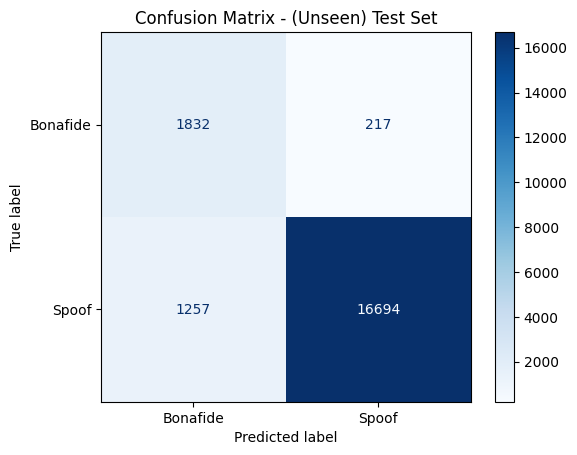

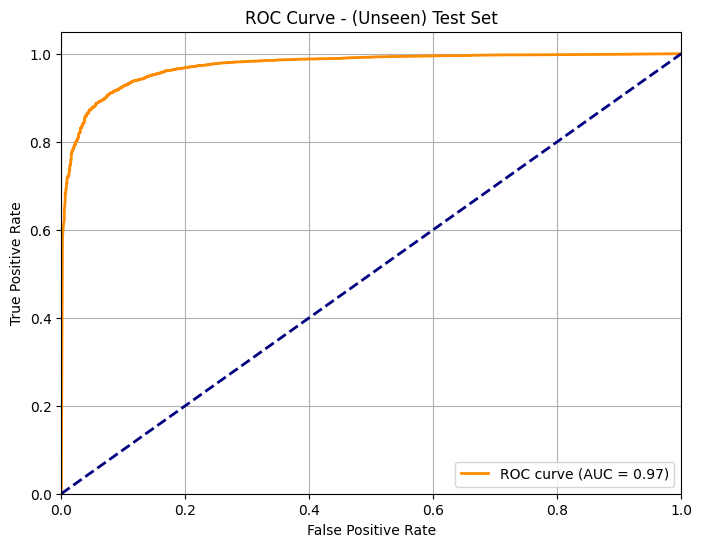

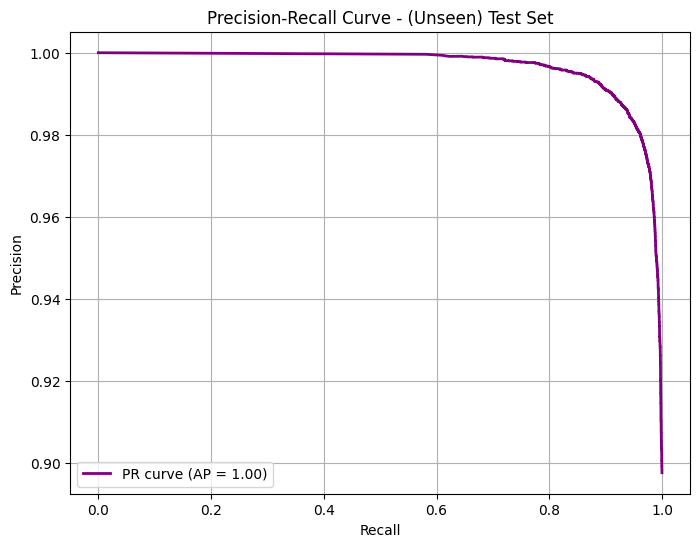

In [18]:
# Predict on the testing set
unseen_test_predictions = model.predict(X_unseen_test)
unseen_test_pred_classes = np.argmax(unseen_test_predictions, axis=1)
unseen_test_true_classes = np.argmax(y_unseen_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(unseen_test_true_classes, unseen_test_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Bonafide", "Spoof"]).plot(cmap="Blues")
plt.title("Confusion Matrix - (Unseen) Test Set")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(unseen_test_true_classes, unseen_test_predictions[:, 1])  # Use the positive class probabilities
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - (Unseen) Test Set")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(unseen_test_true_classes, unseen_test_predictions[:, 1])
average_precision = average_precision_score(unseen_test_true_classes, unseen_test_predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f"PR curve (AP = {average_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - (Unseen) Test Set")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# 6. Fine-Tuning 

### Section 6.1: Definition of new models

In [19]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Model 1: Increased Number of Filters
input_shape = (N_MELS, MAX_TIME_STEPS, 1)
input_layer = Input(shape=input_shape)

x = Conv2D(64, kernel_size=(3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

model1 = Model(inputs=input_layer, outputs=output_layer)
model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model 2: Added Batch Normalization and More Layers
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

model2 = Model(inputs=input_layer, outputs=output_layer)
model2.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model 3: Reduced Dropout with Learning Rate Scheduler
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

model3 = Model(inputs=input_layer, outputs=output_layer)
model3.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Model 4: Simplified Dense Layers with Regularization
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

model4 = Model(inputs=input_layer, outputs=output_layer)
model4.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model 5: Additional Convolutional Layer with Fewer Filters
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

model5 = Model(inputs=input_layer, outputs=output_layer)
model5.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model 6: Bigger Kernels
# First convolutional layer with large kernel
x = Conv2D(32, kernel_size=(7, 7), activation='relu', padding='same')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Second convolutional layer with medium kernel
x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Third convolutional layer with small kernel
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Flatten and Dense layers
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

model6 = Model(inputs=input_layer, outputs=output_layer)
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### Section 6.2: Fitting models

In [ ]:
# Train the Model
#model1.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))
#model2.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))
#model3.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))
#model4.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))
#model5.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))
model6.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 78s 144ms/step - accuracy: 0.8907 - loss: 0.6626 - val_accuracy: 0.9409 - val_loss: 0.1442
Epoch 2/10
202/529 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.9361 - loss: 0.1414

### Section 6.3: Compare models

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import numpy as np

# Function to evaluate and compare models
def evaluate_model(model, X, y, dataset_name):
    predictions = model.predict(X)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y, axis=1)

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_classes, pred_classes)
    ConfusionMatrixDisplay(conf_matrix, display_labels=["Bonafide", "Spoof"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(true_classes, predictions[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {dataset_name}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return roc_auc

# Compare performance of original model and Model 1
models = {"Original Model": model, "Model 6": model6}
datasets = {
    "Training Set": (X_train, y_train),
    "Test Set": (X_test, y_test),
    "(Unseen) Test Set": (X_unseen_test, y_unseen_test)
}

for model_name, current_model in models.items():
    print(f"Evaluating {model_name}")
    for dataset_name, (X, y) in datasets.items():
        print(f"\nDataset: {dataset_name}")
        auc_score = evaluate_model(current_model, X, y, f"{model_name} - {dataset_name}")
        print(f"AUC Score for {model_name} on {dataset_name}: {auc_score:.2f}\n")

### Section 6.4: Export models

In [ ]:
from datetime import datetime

# Generate a dynamic filename with the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
#model1_filename = f"CNN_Model1_{current_time}.h5"  # Dynamic model filename
#model1.save(model1_filename)
#print(f"Model 1 saved as: {model1_filename}")

#model2_filename = f"CNN_Model2_{current_time}.h5"  # Dynamic model filename
#model2.save(model2_filename)
#print(f"Model 2 saved as: {model2_filename}")

#model3_filename = f"CNN_Model3_{current_time}.h5"  # Dynamic model filename
#model3.save(model3_filename)
#print(f"Model 3 saved as: {model3_filename}")

#model4_filename = f"CNN_Model4_{current_time}.h5"  # Dynamic model filename
#model4.save(model4_filename)
#print(f"Model 4 saved as: {model4_filename}")

#model5_filename = f"CNN_Model5_{current_time}.h5"  # Dynamic model filename
#model5.save(model4_filename)
#print(f"Model 5 saved as: {model5_filename}")

model6_filename = f"CNN_Model6_{current_time}.h5"  # Dynamic model filename
model6.save(model6_filename)
print(f"Model 6 saved as: {model6_filename}")


In [ ]:
'''
BEST

# Model 6: Bigger Kernels
# First convolutional layer with large kernel
x = Conv2D(32, kernel_size=(7, 7), activation='relu', padding='same')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Second convolutional layer with medium kernel
x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Third convolutional layer with small kernel
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Flatten and Dense layers
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

model6 = Model(inputs=input_layer, outputs=output_layer)
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

'''

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plt.figure(figsize=(12, 8))
plot_model(model6, to_file=f"{model6_filename}.png", show_shapes=True, show_layer_names=True)
img = plt.imread(f"{model6_filename}.png")
plt.imshow(img)
plt.axis('off')
plt.title("Model Architecture")
plt.show()